# PyTorch TensorBoard Support PyTorch TensorBoard 支持

请观看[youtube视频](https://www.youtube.com/watch?v=6CEld3hZgqc)

## Before You Start 开始之前

要运行本教程，您需要安装 PyTorch、TorchVision、Matplotlib 和 TensorBoard。

### 使用`conda`:
```shell
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard
```
### 使用`pip`:
```shell
pip install torch torchvision matplotlib tensorboard
```

## 介绍 (Introduction)

在这个笔记本中，我们将训练 LeNet-5 的一个变体，使用 Fashion-MNIST 数据集。Fashion-MNIST 是一个包含各种服装图像的集合，共有十个类别标签，每个标签表示图像中展示的服装类型。

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# In case you are using an environment that has TensorFlow installed,
# such as Google Colab, uncomment the following code to avoid
# a bug with saving embeddings to your TensorBoard directory

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

### 在 TensorBoard 中显示图像

让我们从将数据集中的示例图像添加到 TensorBoard 开始：

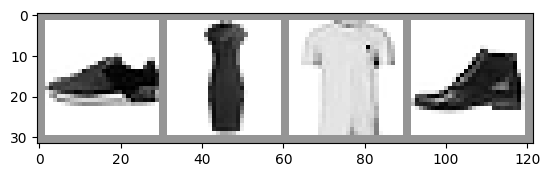

In [2]:
import os

data_path = os.path.expanduser("~/Data/Vision/FashionMNIST")

# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST(data_path,
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST(data_path,
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

上面我们使用了 TorchVision 和 Matplotlib 创建了一个输入数据的 minibatch 的可视化网格。下面，我们使用 `SummaryWriter` 的 `add_image()` 方法记录图像，以便 TensorBoard 使用，并且调用 `flush()` 确保它立即写入磁盘。

In [3]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

### Graphing Scalars to Visualize Training 绘制标量以可视化训练

TensorBoard 是跟踪训练进度和效果的有用工具。下面，我们将运行一个训练循环，跟踪一些指标，并保存数据以供 TensorBoard 使用。

让我们定义一个模型来对图像块进行分类，并为训练定义一个优化器和损失函数：

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

现在让我们训练一个 epoch，并评估每 1000 个批次的训练集损失与验证集损失：

In [5]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            net.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


切换到打开的 TensorBoard `tensorboard --logdir=runs` 并查看 SCALARS 选项卡。

## Visualizing Your Model 可视化你的模型

TensorBoard 还可用于检查模型中的数据流。为此，请使用模型和示例输入调用`add_graph()`方法：

In [6]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

当您切换到 TensorBoard 时，您应该会看到一个 GRAPHS 选项卡。双击“NET”节点以查看模型中的层和数据流。

## Visualizing Your Dataset with Embeddings 使用嵌入可视化您的数据集

我们使用的 28x28 图像块可以建模为 784 维向量（28 * 28 = 784）。将其投影到低维表示是很有意义的。`add_embedding()` 方法会将一组数据投影到方差最高的三个维度，并将其显示为交互式 3D 图表。`add_embedding()` 方法通过投影到方差最高的三个维度来自动完成此操作。

下面，我们将取样数据并生成这样的嵌入：

In [7]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

现在，如果你切换到 TensorBoard 并选择 PROJECTOR 标签，你应该能看到投影的 3D 表示。你可以旋转和缩放模型。查看大尺度和小尺度的内容，看看你是否能发现投影数据中的模式以及标签的聚类。

为了更好地可视化，推荐以下操作：
- 在左侧的 "Color by" 下拉菜单中选择 "label"。
- 切换顶部的 Night Mode 图标，将浅色图像放置在深色背景上。

当你使用 writer.add_embedding() 方法时，TensorBoard 会自动使用一种降维方法（如 PCA 或 t-SNE）将高维数据（例如你传入的 784 维的图像展平特征）投影到三维空间中，以便在 TensorBoard 的 PROJECTOR 选项卡中进行可视化。

具体细节：

- 输入数据维度：例如 28x28 的图像在展平后是 784 维向量。
- 投影：TensorBoard 会将这些 784 维的特征向量通过降维算法（例如 PCA、t-SNE）投影到三维空间（3D）。
- 可视化：最终你会在 TensorBoard 中看到三维空间的嵌入图，可以旋转、缩放，并查看数据点的分布情况。


### 其他资源

如需了解更多信息，请参考以下内容：

- PyTorch 文档中关于 [torch.utils.tensorboard.SummaryWriter](https://pytorch.org/docs/stable/tensorboard.html)
- PyTorch.org 教程中的 [TensorBoard 教程](https://pytorch.org/tutorials/)
- 关于 TensorBoard 的更多信息，请参阅 [TensorBoard 文档](https://www.tensorflow.org/tensorboard?hl=zh-cn)